In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from keras.regularizers import l1_l2
from keras.models import Model, clone_model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Activation, Subtract, merge, Reshape, UpSampling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook
%matplotlib inline

Using TensorFlow backend.


In [2]:
from os import listdir
from os.path import isfile, join
stickyPath = "../../dataset/shuffled-dataset/TrainingSet/"
onlyfiles = [f for f in listdir(stickyPath) if isfile(join(stickyPath, f))]
testData = [f for f in listdir("../../dataset/shuffled-dataset/ValidationSet/") if isfile(join("../../dataset/shuffled-dataset/ValidationSet/", f))]

In [3]:
trainData = onlyfiles[0:int(len(onlyfiles)*0.9)]
valData = onlyfiles[int(len(onlyfiles)*0.9):]

In [4]:
def trainGen(batchSize,stickyPath,_data,vis=False):
    idx = 0
    hshift = (-64,64)
    vshift = (-64,64)
    while(True):
        rows = np.random.randint(0,len(_data),batchSize)
        data = []
        for image in rows:
            data.append(_data[image])
        returnInput=[]
        for image in data:
            skeleton = []
            left = cv2.imread(str(stickyPath+image),cv2.IMREAD_GRAYSCALE)
            #right = data.iloc[row,1]
            #right = cv2.imread(str("../dataset/seen-dataset/TrainingSet/"+right),cv2.IMREAD_GRAYSCALE)

            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            #rightImage = right.astype('float32')
            #rightImage /= 255
            
            temp=[leftImage]
            
            skeleton.append(temp)
            
            # Shifting
            randH = np.random.randint(hshift[0],hshift[1])
            randV = np.random.randint(vshift[0],vshift[1])
            
            leftImageShiftedH=np.roll(axis=0,a=leftImage,shift=randH)
            #rightImageShiftedH=np.roll(axis=0,a=rightImage,shift=randH)
            
            leftImageShiftedV=np.roll(axis=0,a=leftImage,shift=randV)
            #rightImageShiftedV=np.roll(axis=0,a=rightImage,shift=randV)
            
            temp = [leftImageShiftedV]
            skeleton.append(temp)
            temp = [leftImageShiftedH]
            skeleton.append(temp)
            returnInput.append(skeleton)     
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(batchSize*3,64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,3)
        
        if(vis):
            print(returnInput)
        
        yield [returnInput,returnInput]
        
def valGen(stickyPath,_data,vis=False):
    idx = 0
    while(True):
        rows = np.random.randint(0,len(_data),len(_data))
        data = []
        for image in rows:
            data.append(_data[image])
        returnInput=[]
        for image in data:
            skeleton = []
            left = cv2.imread(str(stickyPath+image),cv2.IMREAD_GRAYSCALE)
            #right = data.iloc[row,1]
            #right = cv2.imread(str("../dataset/seen-dataset/TrainingSet/"+right),cv2.IMREAD_GRAYSCALE)

            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            #rightImage = right.astype('float32')
            #rightImage /= 255
            
            temp=[leftImage]
            
            skeleton.append(temp)
            
            returnInput.append(skeleton)     
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(len(_data),64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,3)
        
        if(vis):
            print(returnInput)
        
        yield [returnInput,returnInput]


In [5]:
def cosineDist(vects):
    x, y = vects
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cosineDist_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [6]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
encoded = Dense(8*8*8, activation='relu', name='latent')(encoded)
# model = Model(input_img,encoded)
# print(model.summary())
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(r)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='RMSprop', loss='binary_crossentropy')

#display(SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
batchSize = 25

In [8]:
trainGenObj = trainGen(batchSize,stickyPath,_data=trainData)
valGenObj = valGen(stickyPath,_data=valData)

In [10]:
LOG_DIR = '../log/ae/shuffled'
runIter = 0

In [ ]:
'''

mc = ModelCheckpoint(filepath='../weights/simple_ae_maxpool_shuffled_weights_v1.h5', 
                     monitor='val_loss',period=1,save_best_only=True,
                     save_weights_only=True,mode='auto',verbose=1)
es = EarlyStopping(patience=50, monitor='val_loss', min_delta=0.0005, mode='auto')
tbCallBack = TensorBoard(log_dir=str('../log/ae/shuffled/run'+str(runIter)), histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)
runIter +=1
autoencoder.fit_generator(
    trainGenObj,
    epochs=500,
    verbose=1,
    validation_data=valGenObj,
    validation_steps=1,
    steps_per_epoch=((len(trainData)//batchSize)*3),
    callbacks=[mc,es,tbCallBack]
)

'''

In [13]:
autoencoder.load_weights("../weights/simple_ae_maxpool_shuffled_weights_v1.h5")

In [14]:
testGenObj = valGen("../../dataset/shuffled-dataset/ValidationSet/",_data=testData)

In [15]:
autoencoder.evaluate_generator(testGenObj,steps=1)

0.07141430675983429

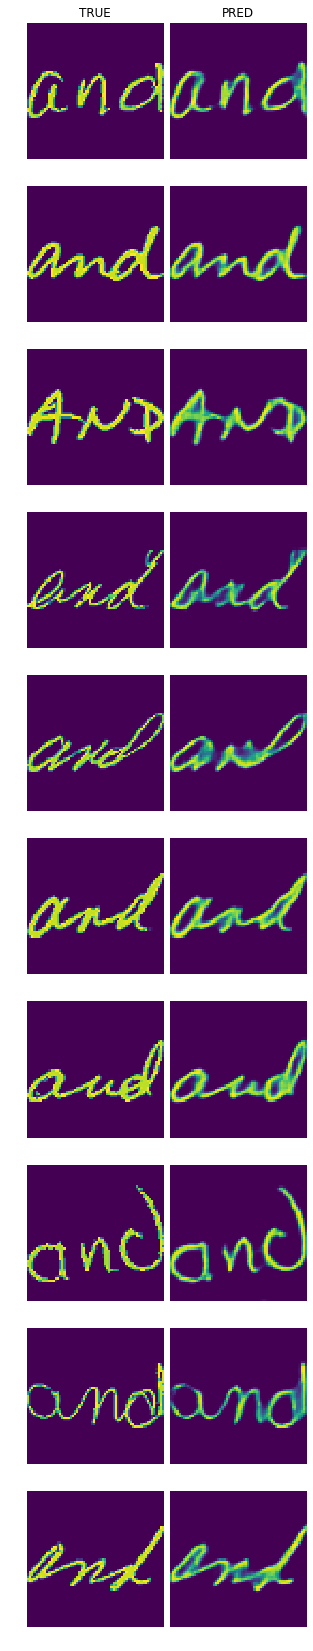

In [16]:
stickyPath = "../../dataset/shuffled-dataset/ValidationSet/"
testImages = [f for f in listdir(stickyPath) if isfile(join(stickyPath, f))]

testGenObj = valGen(stickyPath,testImages)

image1,_ = next(testGenObj)

py = autoencoder.predict(image1[:10])
f,ax = plt.subplots(len(image1[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(image1[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(image1[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(image1[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')

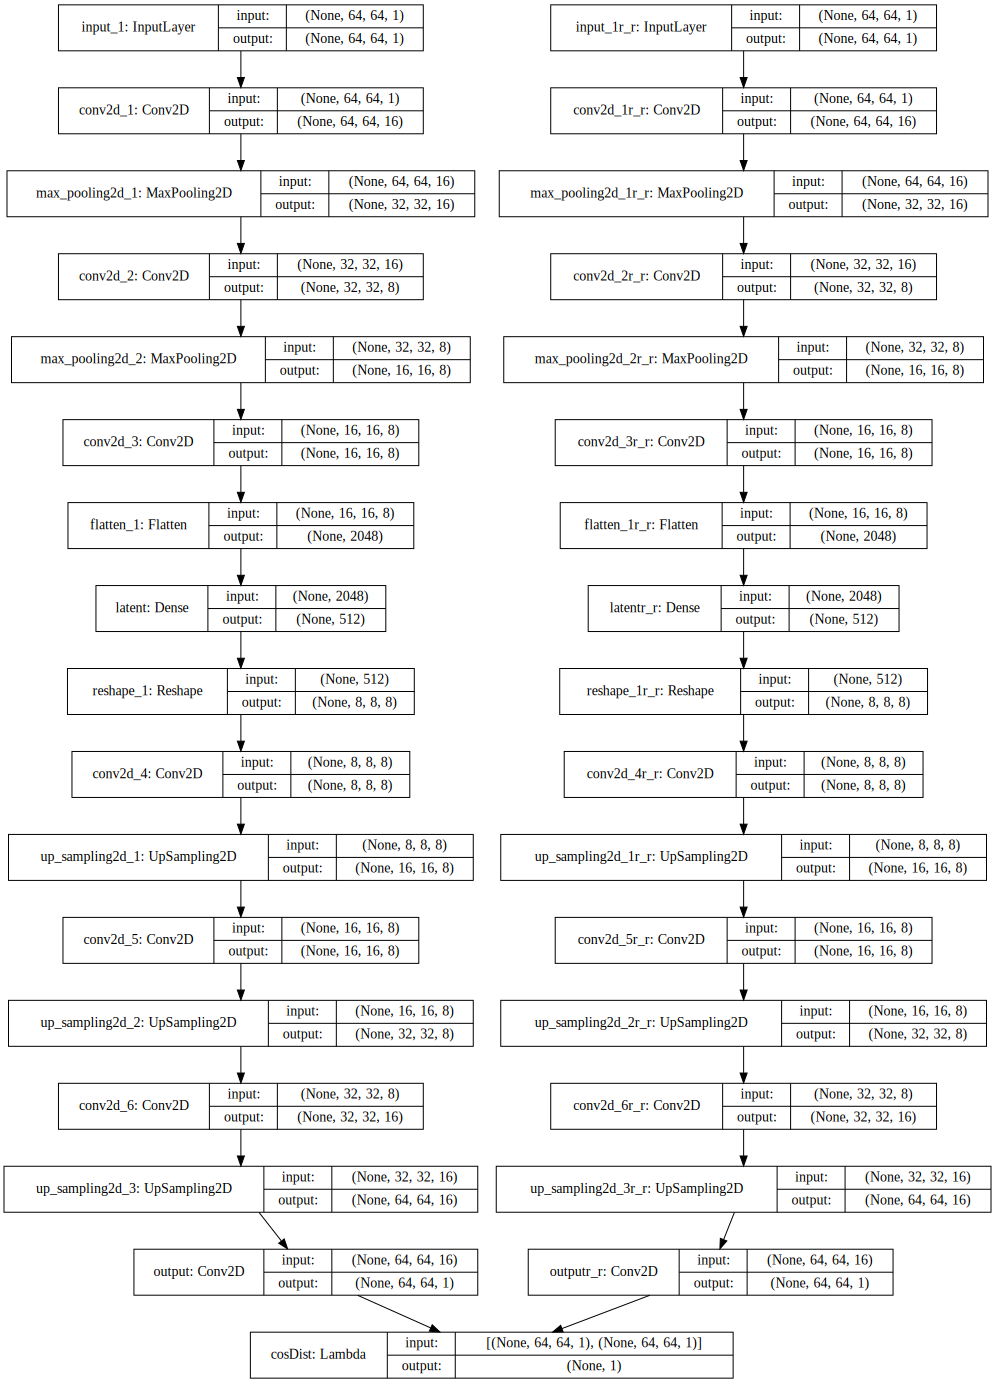

In [28]:
autoencoderLeft = clone_model(autoencoder)
autoencoderRight = clone_model(autoencoder)

for layer in autoencoderRight.layers:
    layer.name = layer.name + str("r_r")

cosDist = Lambda(cosineDist,
                  output_shape=cosineDist_shape,name="cosDist")([autoencoderLeft.output, autoencoderRight.output])

encoderVerification = Model([autoencoderLeft.input,autoencoderRight.input], cosDist)

display(SVG(model_to_dot(encoderVerification, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

## Using Just the Encoder

In [29]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('latent').output)

In [30]:
def buildLatentMatrix(stickyPath,_data,encoder):
    returnInput=[]
    for image in _data:
        skeleton = []
        left = cv2.imread(str(stickyPath+image),cv2.IMREAD_GRAYSCALE)
        #right = data.iloc[row,1]
        #right = cv2.imread(str("../dataset/seen-dataset/TrainingSet/"+right),cv2.IMREAD_GRAYSCALE)

        # Floating Point
        leftImage = left.astype('float32')
        leftImage /= 255
        leftImage = 1 - leftImage
        #rightImage = right.astype('float32')
        #rightImage /= 255

        temp=[leftImage]

        skeleton.append(temp)

        returnInput.append(skeleton)     
    returnInput = np.array(returnInput)
    returnInput = returnInput.reshape(len(_data),64,64)

    blank =[]

    blank.append(returnInput)

    returnInput = np.array(blank)

    returnInput = np.moveaxis(returnInput,0,3)
    
    latentFeatures = encoder.predict(returnInput)
    
    return latentFeatures

In [31]:
latentFeatures = buildLatentMatrix(stickyPath,testImages,encoder)

In [33]:
skeleton = []
for idx in range(len(testImages)):
    skeleton.append([testImages[idx],latentFeatures[idx]])

In [34]:
thresData = pd.DataFrame(data=skeleton,columns=["images","lf"])

In [35]:
thresData["writers"] = thresData["images"].str.split("[a-z]",1,expand=True).iloc[:,0]

In [36]:
thresData = thresData.sort_values(by="writers").reset_index(drop=True)

In [37]:
thresData.head()

,images,lf,writers
0,0001a_num2.png,"[4.305037, 5.3830256, 5.004138, 0.0, 0.0, 0.0,...",0001
1,0001a_num1.png,"[10.145302, 7.6018763, 7.5480227, 0.0, 1.18006...",0001
2,0002a_num2.png,"[8.5055895, 6.5609164, 1.627899, 0.0, 1.295459...",0002
3,0002a_num1.png,"[8.482632, 3.1748013, 4.394835, 0.0, 2.5995908...",0002
4,0004aa_num1.png,"[10.375013, 3.1040015, 8.856609, 0.0, 1.706880...",0004


In [38]:
np.max(cosine_similarity(list(thresData['lf'].values))) - (np.max(cosine_similarity(list(thresData['lf'].values))) - np.min(cosine_similarity(list(thresData['lf'].values))))/2

0.9351152181625366

In [48]:
range(len(thresData))

range(0, 952)

In [126]:
thres = 0.98
tp,tn,fp,fn = 0,0,0,0
testLimiter = 0
for row_idx in tqdm_notebook(range(len(thresData) - testLimiter)):
    idx = 0
    while(idx < len(thresData) - testLimiter):
        cosSim = float(cosine_similarity([thresData.lf[row_idx]],[thresData.lf[idx]]))
        if int(thresData.writers[row_idx]) == int(thresData.writers[idx]) and cosSim > thres:
            tp +=1
        if thresData.writers[row_idx] == thresData.writers[idx] and cosSim < thres:
            fn +=1
        if thresData.writers[row_idx] != thresData.writers[idx] and cosSim < thres:
            tn +=1
        if thresData.writers[row_idx] != thresData.writers[idx] and cosSim > thres:
            fp +=1
        idx +=1

In [127]:
precision = tp/(fp+tp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
total = np.sum((tp,tn,fp,fn))
accuracy = (tp+tn)/total

In [132]:
accuracy

0.9984133359226043

In [129]:
precision

0.6247030878859857

In [130]:
recall

0.566200215285253

In [131]:
f1

0.5940146809712027

In [39]:
cosMat = cosine_similarity(list(thresData['lf'].values))

In [40]:
bins, data = np.histogram(cosMat)

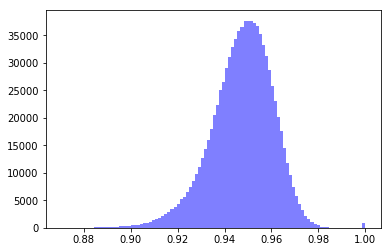

In [41]:
n, bins, patches = plt.hist(cosMat.flatten(), 100, facecolor='blue', alpha=0.5)
plt.show()